<a href="https://colab.research.google.com/github/haytham918/low-rank-expectile/blob/main/LRE_wt_BFGS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from scipy.stats import norm
from scipy.optimize import minimize

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Matrix shape is : (288, 334)
Number of Missing values:  28674
Proportion of Missing values:  29.809131736526943 %
Index of the interval where there is no data at all:  (array([], dtype=int64),)


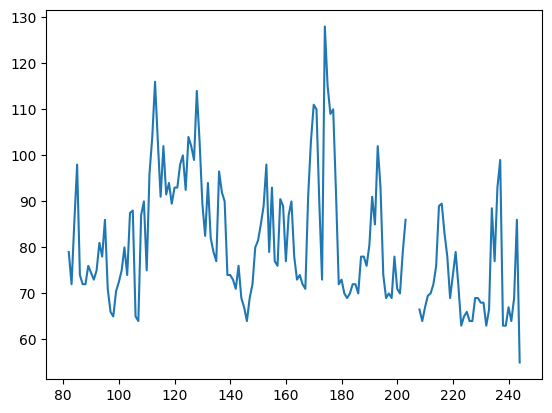

In [9]:
from google.colab import drive
drive.mount('/content/drive')
processed_df = pd.read_csv("/content/drive/MyDrive/low-rank-expectile/processed_heartrate.csv")
# Convert the df to numpy matrix
user_times_matrix = processed_df.values
# Nan Mask Matrix for the matrix
nan_mask = np.isnan(user_times_matrix)

number_missing = np.sum(nan_mask)
matrix_shape = user_times_matrix.shape
print("Matrix shape is :", matrix_shape)
print("Number of Missing values: ", number_missing)
print("Proportion of Missing values: ", number_missing / (matrix_shape[0] * matrix_shape[1]) * 100, "%")

# Check if there is any interval that there is no data from any user
print("Index of the interval where there is no data at all: ", np.where(nan_mask.sum(axis=1) == matrix_shape[1]))
# Get the masked matrix so that we ignore nan values
masked_matrix = np.ma.array(user_times_matrix, mask=nan_mask)
# print(np.mean(masked_matrix, axis=1)[287])
interval_array = np.arange(0, 288)
plt.plot(interval_array, user_times_matrix[:,22])

(array([   39.,   623.,  2952.,  7912., 11553.,  9816.,  4987.,  1658.,
          386.,    74.]),
 array([74.75752753, 75.85816289, 76.95879824, 78.0594336 , 79.16006895,
        80.26070431, 81.36133967, 82.46197502, 83.56261038, 84.66324573,
        85.76388109]),
 <BarContainer object of 10 artists>)

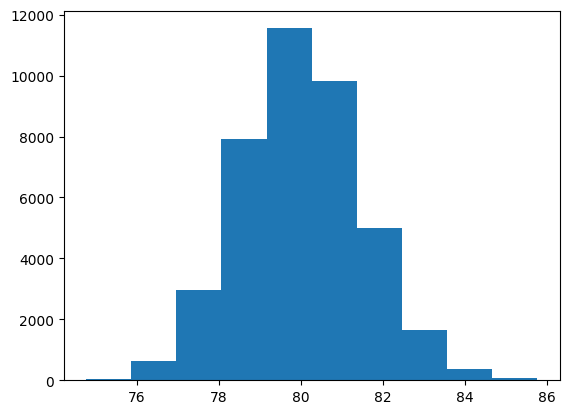

In [29]:
np.random.seed(100)

n_users = 200
n_items = 200
latent_dim = 2

true_r = norm.rvs(loc=40, size=n_users)
true_c = norm.rvs(loc=40, size=n_items)

scale_u_v = 0.1
true_u = norm.rvs(loc=0, size=(n_users, latent_dim), scale=scale_u_v)
true_v = norm.rvs(loc=0, size=(n_items, latent_dim), scale=scale_u_v)

sigma = 0.3

mu_X = true_r[:, np.newaxis] + true_c + np.dot(true_u, true_v.T)

error = sigma * norm.rvs(size=(n_users, n_items))
X = mu_X + error

prob_miss = 0.3
missing = np.random.choice([True, False], size=(n_users, n_items), p=[prob_miss, 1 - prob_miss])
X[missing] = np.nan
X_df = pd.DataFrame(X)

#plt.hist(np.dot(true_u, true_v.T).flat)
plt.hist((true_r[:, np.newaxis] + true_c ).flat)

In [11]:
X_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,NaN,NaN,78.504765,78.150725,77.700688,79.541766,79.509671,76.707226,NaN,77.735387,...,NaN,NaN,77.848575,78.520844,NaN,78.644391,NaN,NaN,78.066753,76.591797
1,NaN,79.569980,81.617518,80.411701,NaN,81.493713,NaN,78.478433,81.104201,NaN,...,NaN,80.203866,NaN,80.353559,79.753492,80.820639,78.593043,NaN,NaN,NaN
2,81.490014,NaN,NaN,NaN,81.159164,NaN,82.528457,NaN,81.742098,NaN,...,81.288606,80.908280,80.985140,80.750956,81.416015,80.552663,79.030560,81.159384,NaN,NaN
3,80.505473,79.008618,80.328935,NaN,80.036025,81.190695,NaN,78.030281,NaN,78.916386,...,NaN,NaN,NaN,79.811437,NaN,79.652887,NaN,80.898494,80.115202,77.916907
4,NaN,NaN,81.701824,NaN,80.624811,81.912051,NaN,79.366947,NaN,80.402341,...,80.360145,NaN,80.551517,80.206477,NaN,80.808765,79.135620,81.755223,81.235284,79.535631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,81.273040,80.039811,81.641060,79.707987,NaN,NaN,82.243622,78.938519,81.218670,NaN,...,80.265971,80.910805,80.663148,NaN,81.155635,NaN,79.050296,NaN,80.191933,80.080882
196,80.305422,NaN,80.391725,79.218281,79.893416,NaN,81.371051,NaN,79.869174,79.400048,...,NaN,NaN,79.108890,80.536248,79.772900,79.833724,77.873170,80.711737,NaN,78.667212
197,NaN,NaN,81.618331,NaN,81.050873,82.402183,82.387863,79.748744,81.746046,80.003892,...,80.984891,80.988751,81.267432,81.079089,81.306831,NaN,78.912447,81.886555,81.001648,79.800544
198,79.239306,78.631173,80.401429,79.201403,79.596998,80.449956,81.131732,NaN,79.955943,79.082377,...,79.475952,78.878109,79.060991,79.284905,78.798293,79.351620,NaN,NaN,NaN,78.197512


In [12]:
true_u

array([[-0.01977973, -0.08546728],
       [ 0.00235975, -0.01704565],
       [-0.10696663,  0.02258387],
       [-0.08676595,  0.04184152],
       [-0.23052582,  0.01621556],
       [-0.05788411, -0.03992846],
       [ 0.14878944, -0.03578169],
       [ 0.03564309,  0.10312822],
       [ 0.15225431, -0.10164811],
       [ 0.11284148, -0.09272486],
       [-0.11927714,  0.13748594],
       [-0.0703237 ,  0.02442071],
       [ 0.10323459,  0.16169399],
       [-0.00548302, -0.02480113],
       [-0.03967249, -0.0033547 ],
       [ 0.1032918 , -0.19898222],
       [-0.02780337,  0.07656954],
       [ 0.07441496, -0.17231933],
       [ 0.10303924,  0.00597148],
       [-0.09342158, -0.10624411],
       [-0.06294459, -0.03022844],
       [ 0.10396389, -0.09309697],
       [-0.12776291, -0.094432  ],
       [-0.03188074, -0.20842709],
       [ 0.12703115,  0.00308778],
       [ 0.06531759,  0.05583469],
       [ 0.01363975, -0.03373384],
       [-0.13371651, -0.0411491 ],
       [-0.01077762,

In [13]:
def get_observed_mask(X):
    return ~np.isnan(X)

def compute_expectile_gradients_vectorized(X, R, C, U, V, M, tau):
    m, n = X.shape
    k = U.shape[1]

    # Construct approximation and error matrices
    approx_matrix = R[:, np.newaxis] + C + U @ V.T
    error_matrix = X - approx_matrix
    error_matrix[~M] = 0  # Ignore missing values

    # Get weight
    W = np.where(error_matrix >= 0, tau, 1 - tau)

    # Calculate gradient
    R_grad = -2 * np.sum(W * error_matrix, axis=1) / M.sum()
    C_grad = -2 * np.sum(W * error_matrix, axis=0) / M.sum()
    U_grad = -2 * (W * error_matrix) @ V / M.sum()
    V_grad = -2 * (W * error_matrix).T @ U / M.sum()

    return R_grad, C_grad, U_grad, V_grad

def expectile_loss_vectorized(X, R, C, U, V, M, tau):
    approx_matrix = R[:, np.newaxis] + C + U @ V.T
    error_matrix = X - approx_matrix
    error_matrix[~M] = 0  # Ignore missing values

    W = np.where(error_matrix >= 0, tau, 1 - tau)
    loss = np.sum(W * error_matrix**2) / M.sum()

    return loss

def expectile_gradient_descent_vectorized(X, k, epochs, eta, tau):
    m, n = X.shape
    R = np.zeros(m)
    C = np.zeros(n)
    U = np.random.normal(0, 0.1, (m, k))
    V = np.random.normal(0, 0.1, (n, k))
    M = get_observed_mask(X)

    for epoch in range(epochs):
        R_grad, C_grad, U_grad, V_grad = compute_expectile_gradients_vectorized(X, R, C, U, V, M, tau)
        R -= eta * R_grad
        C -= eta * C_grad
        U -= eta * U_grad
        V -= eta * V_grad

        if epoch % 10 == 9:
            current_loss = expectile_loss_vectorized(X, R, C, U, V, M, tau)
            print(f"Epoch {epoch+1}: Loss = {current_loss}")

    return R, C, U, V

In [58]:
def flatten_parameters(R, C, U, V):
    return np.concatenate([R, C, U.flatten(), V.flatten()])

def unflatten_parameters(params, m, n, k):
    R = params[:m]
    C = params[m:m+n]
    U = params[m+n:m+n+m*k].reshape(m, k)
    V = params[m+n+m*k:].reshape(n, k)
    return R, C, U, V

def total_loss_and_gradient(params, X, M, tau, m, n, k):
    R, C, U, V = unflatten_parameters(params, m, n, k)
    approx_matrix = R[:, np.newaxis] + C + U @ V.T
    error_matrix = X - approx_matrix
    error_matrix[~M] = 0  # Ignore missing values

    W = np.where(error_matrix >= 0, tau, 1 - tau)
    loss = np.sum(W * error_matrix**2) / M.sum()

    R_grad = -2 * np.sum(W * error_matrix, axis=1) / M.sum()
    C_grad = -2 * np.sum(W * error_matrix, axis=0) / M.sum()
    U_grad = -2 * (W * error_matrix) @ V / M.sum()
    V_grad = -2 * (W * error_matrix).T @ U / M.sum()

    grad = flatten_parameters(R_grad, C_grad, U_grad, V_grad)
    return loss, grad
global iteration
def print_iteration(x):

    iteration += 1
    print(f"Iteration {iteration}")

def optimize_with_bfgs(X, k, tau):

    m, n = X.shape
    M = get_observed_mask(X)
    initial_params = np.random.normal(0, 0.3, m + n + m*k + n*k)

    result = minimize(total_loss_and_gradient, initial_params, args=(X, M, tau, m, n, k),
                      method='BFGS', jac=True, options={'disp': True})

    final_params = result.x
    final_loss = result.fun
    R, C, U, V = unflatten_parameters(final_params, m, n, k)
    print(f"Final Loss: {final_loss}")
    return R, C, U, V

def optimize_with_lbfgs(X, k, tau):
    m, n = X.shape
    M = get_observed_mask(X)
    initial_params = np.random.normal(0, 0.3, m + n + m*k + n*k)

    result = minimize(total_loss_and_gradient, initial_params, args=(X, M, tau, m, n, k),
                      method='L-BFGS-B', jac=True, options={'disp': True})

    final_params = result.x
    final_loss = result.fun
    R, C, U, V = unflatten_parameters(final_params, m, n, k)
    print(f"Final Loss: {final_loss}")
    return R, C, U, V


In [52]:
M = get_observed_mask(X)
M.sum()

28072

In [61]:
# epochs = 350
eta = 0.1
tau = 0.5
# R, C, U, V = expectile_gradient_descent_vectorized(X, latent_dim, epochs, eta, tau)

# BFGS
R, C, U, V = optimize_with_bfgs(X, 2, tau)

# LBFGS
# R_l, C_l, U_l, V_l = optimize_with_lbfgs(X, 2, tau)

Optimization terminated successfully.
         Current function value: 0.042652
         Iterations: 210
         Function evaluations: 214
         Gradient evaluations: 214
Final Loss: 0.04265235362597217


In [62]:
# LBFGS
R_l, C_l, U_l, V_l = optimize_with_lbfgs(X, 2, tau)

Final Loss: 0.04205854445686314


In [64]:
X_hat = R[:, np.newaxis] + C + U @ V.T
X_hat

X_hat_l = R_l[:, np.newaxis] + C_l, + U_l @ V_l.T
X_hat_l

(array([[50.52270204, 49.59883331, 51.20983351, ..., 49.87056693,
         50.1681615 , 49.62251215],
        [53.61853563, 52.69466691, 54.3056671 , ..., 52.96640052,
         53.2639951 , 52.71834574],
        [52.65947646, 51.73560773, 53.34660793, ..., 52.00734134,
         52.30493592, 51.75928656],
        ...,
        [54.09131074, 53.16744201, 54.77844221, ..., 53.43917563,
         53.7367702 , 53.19112085],
        [51.52575345, 50.60188472, 52.21288492, ..., 50.87361833,
         51.17121291, 50.62556355],
        [53.27944303, 52.35557431, 53.9665745 , ..., 52.62730792,
         52.92490249, 52.37925314]]),
 array([[28.30982686, 27.73969843, 27.56695558, ..., 29.21058973,
         27.79433951, 27.31670134],
        [27.35083161, 26.83456185, 26.67779624, ..., 28.18434866,
         26.88416234, 26.46868707],
        [29.01609474, 28.51771437, 28.36586087, ..., 29.84791574,
         28.56578078, 28.1906615 ],
        ...,
        [27.50044607, 27.01034468, 26.86121943, ..., 2

In [65]:
print("BFGS Feature Difference: ", X_hat - mu_X)
#type(X_hat)
#X_hat.shape
residual = (X_hat - mu_X).ravel().std()
print("BFGS Residual: ", residual)
#type(residual)
# plt.hist(residual)
print("LBFGS Featrue Difference: ", X_hat_l - mu_X)
residual_l = (X_hat_l - mu_X).ravel().std()
print("LBFGS Residual: ", residual_l)

BFGS Feature Difference:  [[-0.016709    0.0417585  -0.08929303 ...  0.04034128 -0.07289541
  -0.0400046 ]
 [ 0.0198757   0.09327727  0.05476988 ...  0.02029364  0.04345385
   0.04921977]
 [-0.0812415   0.02359619  0.05716697 ... -0.07765102 -0.00301197
  -0.06084378]
 ...
 [-0.04205544  0.07707297  0.19214601 ... -0.07950203  0.11109384
   0.01764769]
 [ 0.01746423  0.07413946 -0.03265112 ...  0.0608633  -0.00909416
   0.007787  ]
 [-0.08616804 -0.02012712 -0.11098567 ... -0.04947583 -0.10254007
  -0.08723113]]
BFGS Residual:  0.06921779691353946
LBFGS Featrue Difference:  [[[-28.32341496 -27.73913942 -27.62744307 ... -29.15383094 -27.8353295
   -27.43500107]
  [-27.32734174 -26.7401791  -26.62775769 ... -28.15926314 -26.84279775
   -26.43774043]
  [-29.09175374 -28.50752032 -28.40484652 ... -29.91215756 -28.62157865
   -28.22088472]
  ...
  [-27.5216788  -26.93835599 -26.83530668 ... -28.34227758 -27.04918246
   -26.65000918]
  [-28.45797283 -27.8784386  -27.76733311 ... -29.28658155

In [66]:
print("BFGS R's diff: ",true_r - R)
print("LBFGS R's diff: ", true_r - R_l)

BFGS R's diff:  [ 1.47435560e+00 -3.82057962e-01  3.53945568e+00 -1.99297101e+00
  1.45223949e+00  1.64371950e+00  3.27392959e+00 -2.74326045e+00
  2.75430796e+00 -1.57261362e+00  1.74229731e-01  1.40674909e+00
 -7.64083265e-01  8.75900536e-01 -2.65119851e+00  5.97632278e-01
 -2.42572907e-01 -2.03133602e+00  2.98037139e+00  9.59939569e-01
  3.35337326e+00  2.38390178e+00 -3.71559170e+00 -2.55741880e+00
 -3.78935857e+00 -1.50921187e+00  3.36542562e+00 -7.74722695e-01
 -2.89111526e+00 -2.77227142e-01 -1.20813310e+00 -2.95346172e+00
 -2.79247910e+00  1.58208460e-01  6.20193677e-01  2.57839524e+00
  8.38408552e-01 -3.39834441e+00  3.07611842e-01  7.41448080e-02
  1.71319618e+00  1.23698178e+00  3.49079446e+00 -4.63839775e+00
  1.04481334e+00  3.69840860e+00 -3.25374804e+00  4.45694237e+00
  1.38855300e+00  7.49722748e-01 -2.39996485e-01 -3.56799164e-01
 -1.17499619e+00  2.79129709e+00 -5.75178784e-01  4.07454300e+00
  7.87570501e-01  1.27430348e-01  1.27465862e+00 -1.01989246e+00
  3.02065

In [23]:
print("BFGS C's difference: ", true_c - C)
print("LBFGS C's difference: ", true_c - C_l)

BFGS C's difference:  [ 0.91911542  0.70541772  0.11138443  1.21702615  0.67467798  0.15852563
  0.91679787  1.58956414  0.23015215  1.79632181  0.81337912  0.79601165
  0.03854686 -0.25836448  0.28009505  1.33852055  1.26452007  0.33318629
  1.22136425  0.86163102  0.37172928  1.12127739  1.68859417  1.36583813
  1.22093847  1.1493551   1.53731265  0.12830569  1.18685983  1.23104701
  1.04177848  2.32843223  1.33959314  0.13201416  0.84304244  1.0997723
  0.85390478  0.23616532  0.7285799   1.56204674  0.67654195  0.72699236
  0.40020196  1.34993512  1.85584067  0.99331754  1.12552281  1.07556896
  1.2937249   0.99833474  1.02278394  1.56170518  1.49802434  1.27258592
  0.57001269  0.91455833  0.53582551  0.8347      1.13894595  1.16344181
  1.32685823  0.71335729  1.55580548  0.97878551  0.36018577  0.72023473
  0.70152157  1.422506    0.55734735  0.48645221  1.46866052  1.05185251
  0.4116151   0.44124761  0.05944474  0.00564517  0.25584813  1.20747078
  0.79327671  1.69153095  0.85

In [68]:
print("BFGS difference in outer: ", np.outer(U, V) - np.outer(true_u, true_v))
print("LBFGS difference in outer: ", np.outer(U_l, V_l) - np.outer(true_u, true_v))

BFGS difference in outer:  [[ 2.43224578  0.67014555  1.91171937 ...  3.95767081  1.36427204
   2.2545382 ]
 [-0.94170474 -0.25372458 -0.74217178 ... -1.52823508 -0.539932
  -0.86857649]
 [ 0.88258444  0.24258671  0.69390702 ...  1.43569511  0.49625109
   0.81765717]
 ...
 [-1.2330072  -0.32646783 -0.97375481 ... -1.99689336 -0.7186795
  -1.13293071]
 [ 2.40147732  0.65992678  1.88814307 ...  3.90636865  1.35056966
   2.22470574]
 [-0.93266812 -0.24831342 -0.73608811 ... -1.51145615 -0.54082911
  -0.85799891]]
LBFGS difference in outer:  [[ 40.40842919  10.3945694   40.44006924 ...  10.86681427  40.88207058
   11.65808301]
 [-47.02613744 -12.09006126 -47.0670525  ... -12.63058642 -47.59469193
  -13.55705935]
 [ 38.33302934   9.85936817  38.36384136 ...  10.30559429  38.78572144
   11.05731686]
 ...
 [-44.41107055 -11.409915   -44.4544032  ... -11.90999579 -44.96789344
  -12.79138922]
 [ 40.06454603  10.30432518  40.09698601 ...  10.77018478  40.53868714
   11.55618706]
 [-43.76864191 -

In [ ]:
# TRY USING PYTORCH LBFGS

# Create Tensors
train_tensor = torch.tensor(X, dtype=torch.float32)
print(train_tensor)


# Model definition
class LRModel(nn.Module):
  def __init__(self, number_users, number_times, rank):
    super().__init__()
    self.U = nn.Embedding(number_users, rank)
    self.V = nn.Embedding(number_times, rank)

    self.additive_row = nn.Embedding(number_users, 1)
    self.additive_column = nn.Embedding(number_times, 1)

    # Initializing the bias terms to zeros
    self.additive_row.weight.data.fill_(0.)
    self.additive_column.weight.data.fill_(0.)


  # Define forward propagation
  def forward(self, user, times):
    # print(self.U(user).shape)
    # print(self.V(times).shape)
    pred = self.U(user) * self.V(times)
    pred = pred.sum(1, keepdim=False)
    pred += self.additive_row(user).squeeze() + self.additive_column(times).squeeze()
    return pred

# Define Loss function excluding missing values
def loss_func(params, m, n, k):
    R = np.array(params.additive_row).reshape(1)[:m]
    print(R[2])
    C = np.array(params.additive_row).reshape(-1)[m:m+n]
    print(params.U)
    U = np.array(params.U).reshape(-1)[m+n:m+n+m*k].reshape(m, k)
    V = params.V[m+n+m*k:].reshape(n, k)
    approx_matrix = R[:, np.newaxis] + C + U @ V.T
    error_matrix = X - approx_matrix
    error_matrix[~M] = 0  # Ignore missing values

    W = np.where(error_matrix >= 0, tau, 1 - tau)
    loss = np.sum(W * error_matrix**2) / M.sum()
    return loss
# Define parameters in our case
number_users, number_times = X.shape
rank = 6
model = LRModel(number_users, number_times, rank)

optimizer = torch.optim.LBFGS(model.parameters(), lr=0.01)

# Epochs and CheckpointPath
number_epochs = 300

# global_best_loss = float('inf')
# best_epoch = 0
for i in range(number_epochs):
  user_indices = torch.arange(number_users).repeat_interleave(number_times)
  time_indices = torch.arange(number_times).repeat(number_users)
  output = model(user_indices, time_indices)

  # Calculate loss
  training_loss = loss_func(model, X.shape[0], X.shape[1], rank)
  if(i % 10 == 0):
    print(f"Training Epoch {i} loss: ", training_loss)

  # Backward
  optimizer.zero_grad()
  training_loss.backward()
  optimizer.step()


In [25]:
# Real Data with LBFGS
eta = 0.1
tau = 0.6
R_l, C_l, U_l, V_l = optimize_with_lbfgs(user_times_matrix, 2, tau)

Final Loss: 65.44281880268501


In [ ]:
# epochs = 1000
eta = 0.1
tau = 0.6
# R, C, U, V = expectile_gradient_descent_vectorized(user_times_matrix, 2, epochs, eta, tau)
R, C, U, V = optimize_with_bfgs(user_times_matrix, 2, tau)